In [2]:
import numpy as np
import matplotlib.pyplot as plt
import tensorflow as tf
from IPython.display import clear_output
import scipy.io
import os

### Get the relative position for just one timestep:

In [3]:
#Take an entire X_pos and Y_pos array, get the relative position for each X and Y.
def get_relative_positions(X_pos, Y_pos, index):
    rel_X = X_pos - np.reshape(X_pos.T[index], [X_pos.shape[0], -1])
    rel_Y = Y_pos - np.reshape(Y_pos.T[index], [Y_pos.shape[0], -1])
    #Experimental: Theoretically, the exact position of the particle should not be an indicator of its type, or even
    #play any helpful effect along with the relative positions, so we delete it from our inputs.
    rel_X = np.delete(rel_X, index, 1)
    rel_Y = np.delete(rel_Y, index, 1)  
    return rel_X, rel_Y

### Do relative positions for all timesteps in a full simulation:

In [4]:
def transform_to_relative(X_pos, Y_pos, ivel):
    all_rel_X = np.array([])
    all_rel_Y = np.array([])
    labels = np.array([])
    for index in range(X_pos.shape[1]):
        rel_X, rel_Y = get_relative_positions(X_pos, Y_pos, index)
        labels = np.append(labels, np.repeat(ivel[index], X_pos.shape[0]))
        all_rel_X = np.reshape(np.append(all_rel_X, rel_X), [-1, rel_X.shape[1]])
        all_rel_Y = np.reshape(np.append(all_rel_Y, rel_Y), [-1, rel_Y.shape[1]])
    all_rel_pos = np.concatenate([all_rel_X, all_rel_Y], axis = 1)
    labels = np.reshape(labels, [all_rel_pos.shape[0], 1])
    return all_rel_pos, labels

### Relative positions for many simulations shuffled together:

In [59]:
#Get the list of all files in the specified folder, and shuffle them to generalize:
folder = np.array(os.listdir('CoPhe_Lab/1st_May'))
folder = folder[np.random.permutation(len(folder))]
folder_name = "Cophe_Lab\\1st_May\\"

#Specify number of files to process:
file_num = len(folder)
print("Files to process = ", file_num)
_ = input("Press Enter to continue")

file = scipy.io.loadmat(folder_name + folder[0])

#Initialize the array for the XA and YA positions
all_Xpos = np.array(file['XA']).T
all_Ypos = np.array(file['YA']).T

#Get the Velocities along X-direction for current file:
VXA = file['VXA']

#Extract the first timestep, the initial velocity, and divide it by its magnitude to get the direction (1 or -1)
ivel = (VXA[:, 0]/abs(VXA[0, 0]))
# = ((ivel + 1)/2).astype('int')

X, Y = transform_to_relative(all_Xpos, all_Ypos, ivel)

processed = 1

for i in range(1, file_num):
    
    file = scipy.io.loadmat(folder_name + folder[0])

    #Initialize the array for the XA and YA positions
    all_Xpos = np.array(file['XA']).T
    all_Ypos = np.array(file['YA']).T

    #Get the Velocities along X-direction for current file:
    VXA = file['VXA']

    #Extract the first timestep, the initial velocity, and divide it by its magnitude to get the direction (1 or -1)
    ivel = (VXA[:, 0]/abs(VXA[0, 0]))
    #ivel = ((ivel + 1)/2).astype('int')

    X_curr, Y_curr = transform_to_relative(all_Xpos, all_Ypos, ivel)
    
    X = np.concatenate((X, X_curr), axis = 0)
    Y = np.concatenate((Y, Y_curr), axis = 0)
    
    processed += 1
    print("Files read = ", processed)
    clear_output(wait=True)

X.shape, Y.shape

Files to process =  7800


KeyboardInterrupt: Interrupted by user

## MODEL:

In [49]:
layer_nodes = [50, 60, 90, 60, 1]
#layer_nodes = [20, 30, 40, 50, 60, 70, 80, 70, 60, 50, 40, 30, 20, 1] # 13 layers
dropout_probs = [0, 0.2, 0.2, 0.2, 0] #0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.2, 0.1, 0]

#Activations:
sigmoid = tf.keras.activations.sigmoid
relu = tf.keras.activations.relu
tanh = tf.keras.activations.tanh

activations = [tanh, tanh, tanh, tanh, tanh] #, tanh, tanh, tanh, tanh, tanh, tanh, tanh, tanh, tanh]
inputs = tf.keras.layers.Input(shape = (82,))
layer_output = tf.keras.layers.Dense(units = layer_nodes[0], activation = 'tanh')(inputs)
layer_output = tf.keras.layers.Dropout(dropout_probs[0])(layer_output)
layer_output = tf.keras.layers.BatchNormalization()(layer_output)

for i in range(1, len(layer_nodes)-1):
    layer_output = tf.keras.layers.Dense(units = layer_nodes[i], activation = activations[i])(layer_output)
    layer_output = tf.keras.layers.Dropout(dropout_probs[i])(layer_output)
    layer_output = tf.keras.layers.BatchNormalization()(layer_output)
    
layer_output = tf.keras.layers.Dense(units = layer_nodes[-1], activation = activations[-1])(layer_output)

In [50]:
relative_model = tf.keras.Model(inputs = inputs, outputs = layer_output)
relative_model.summary()

Model: "model_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_10 (InputLayer)       [(None, 82)]              0         
                                                                 
 dense_45 (Dense)            (None, 50)                4150      
                                                                 
 dropout_36 (Dropout)        (None, 50)                0         
                                                                 
 batch_normalization_27 (Bat  (None, 50)               200       
 chNormalization)                                                
                                                                 
 dense_46 (Dense)            (None, 60)                3060      
                                                                 
 dropout_37 (Dropout)        (None, 60)                0         
                                                           

In [51]:
relative_model.compile(optimizer = tf.keras.optimizers.Adam(learning_rate = 0.001), 
              loss = 'mean_squared_error',
             metrics = [tf.keras.metrics.Accuracy()])

In [58]:
history = relative_model.fit(x = X, y = Y, batch_size = 420420, epochs = 2000)

Epoch 1/2000
1/1 [==============================] - 1s 1s/step - loss: 0.2881 - accuracy: 0.0233
Epoch 2/2000
1/1 [==============================] - 1s 952ms/step - loss: 0.2882 - accuracy: 0.0233
Epoch 3/2000
1/1 [==============================] - 1s 941ms/step - loss: 0.2881 - accuracy: 0.0234
Epoch 4/2000
1/1 [==============================] - 1s 941ms/step - loss: 0.2881 - accuracy: 0.0234
Epoch 5/2000
1/1 [==============================] - 1s 950ms/step - loss: 0.2881 - accuracy: 0.0233
Epoch 6/2000
1/1 [==============================] - 1s 949ms/step - loss: 0.2881 - accuracy: 0.0233
Epoch 7/2000
1/1 [==============================] - 1s 942ms/step - loss: 0.2880 - accuracy: 0.0234
Epoch 8/2000
1/1 [==============================] - 1s 944ms/step - loss: 0.2881 - accuracy: 0.0233
Epoch 9/2000
1/1 [==============================] - 1s 947ms/step - loss: 0.2881 - accuracy: 0.0234
Epoch 10/2000
1/1 [==============================] - 1s 955ms/step - loss: 0.2880 - accuracy: 0.0233
Ep

1/1 [==============================] - 1s 946ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 83/2000
1/1 [==============================] - 1s 944ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 84/2000
1/1 [==============================] - 1s 943ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 85/2000
1/1 [==============================] - 1s 947ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 86/2000
1/1 [==============================] - 1s 945ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 87/2000
1/1 [==============================] - 1s 941ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 88/2000
1/1 [==============================] - 1s 940ms/step - loss: 0.2872 - accuracy: 0.0234
Epoch 89/2000
1/1 [==============================] - 1s 940ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 90/2000
1/1 [==============================] - 1s 945ms/step - loss: 0.2873 - accuracy: 0.0234
Epoch 91/2000
1/1 [==============================] - 1s 949ms/step - loss: 0.2873 - accuracy: 0.0235
Epoc

1/1 [==============================] - 1s 943ms/step - loss: 0.2868 - accuracy: 0.0235
Epoch 163/2000
1/1 [==============================] - 1s 944ms/step - loss: 0.2869 - accuracy: 0.0235
Epoch 164/2000
1/1 [==============================] - 1s 950ms/step - loss: 0.2869 - accuracy: 0.0235
Epoch 165/2000
1/1 [==============================] - 1s 943ms/step - loss: 0.2868 - accuracy: 0.0235
Epoch 166/2000
1/1 [==============================] - 1s 946ms/step - loss: 0.2868 - accuracy: 0.0235
Epoch 167/2000
1/1 [==============================] - 1s 948ms/step - loss: 0.2868 - accuracy: 0.0235
Epoch 168/2000
1/1 [==============================] - 1s 949ms/step - loss: 0.2869 - accuracy: 0.0235
Epoch 169/2000
1/1 [==============================] - 1s 941ms/step - loss: 0.2868 - accuracy: 0.0235
Epoch 170/2000
1/1 [==============================] - 1s 941ms/step - loss: 0.2868 - accuracy: 0.0235
Epoch 171/2000
1/1 [==============================] - 1s 944ms/step - loss: 0.2869 - accuracy: 0.

1/1 [==============================] - 1s 941ms/step - loss: 0.2865 - accuracy: 0.0235
Epoch 243/2000
1/1 [==============================] - 1s 939ms/step - loss: 0.2865 - accuracy: 0.0235
Epoch 244/2000
1/1 [==============================] - 1s 941ms/step - loss: 0.2865 - accuracy: 0.0235
Epoch 245/2000
1/1 [==============================] - 1s 938ms/step - loss: 0.2865 - accuracy: 0.0236
Epoch 246/2000
1/1 [==============================] - 1s 943ms/step - loss: 0.2866 - accuracy: 0.0235
Epoch 247/2000
1/1 [==============================] - 1s 952ms/step - loss: 0.2865 - accuracy: 0.0235
Epoch 248/2000
1/1 [==============================] - 1s 945ms/step - loss: 0.2865 - accuracy: 0.0236
Epoch 249/2000
1/1 [==============================] - 1s 940ms/step - loss: 0.2865 - accuracy: 0.0235
Epoch 250/2000
1/1 [==============================] - 1s 941ms/step - loss: 0.2865 - accuracy: 0.0235
Epoch 251/2000
1/1 [==============================] - 1s 950ms/step - loss: 0.2866 - accuracy: 0.

1/1 [==============================] - 0s 168ms/step - loss: 0.2864 - accuracy: 0.0235
Epoch 323/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2864 - accuracy: 0.0236
Epoch 324/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.2864 - accuracy: 0.0235
Epoch 325/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.2864 - accuracy: 0.0235
Epoch 326/2000
1/1 [==============================] - 0s 174ms/step - loss: 0.2864 - accuracy: 0.0235
Epoch 327/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2864 - accuracy: 0.0235
Epoch 328/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2863 - accuracy: 0.0235
Epoch 329/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2863 - accuracy: 0.0236
Epoch 330/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2864 - accuracy: 0.0235
Epoch 331/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2864 - accuracy: 0.

1/1 [==============================] - 0s 168ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 403/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 404/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 405/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 406/2000
1/1 [==============================] - 0s 175ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 407/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2863 - accuracy: 0.0236
Epoch 408/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 409/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 410/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 411/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2862 - accuracy: 0.

1/1 [==============================] - 0s 170ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 483/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 484/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 485/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2862 - accuracy: 0.0236
Epoch 486/2000
1/1 [==============================] - 0s 185ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 487/2000
1/1 [==============================] - 0s 174ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 488/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 489/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 490/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 491/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2861 - accuracy: 0.

1/1 [==============================] - 0s 166ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 563/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 564/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 565/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 566/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 567/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 568/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 569/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2861 - accuracy: 0.0236
Epoch 570/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 571/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.2860 - accuracy: 0.

1/1 [==============================] - 0s 169ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 643/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 644/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 645/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 646/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 647/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 648/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 649/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 650/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 651/2000
1/1 [==============================] - 0s 179ms/step - loss: 0.2860 - accuracy: 0.

1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 723/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 724/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 725/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 726/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 727/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 728/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 729/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 730/2000
1/1 [==============================] - 0s 179ms/step - loss: 0.2860 - accuracy: 0.0236
Epoch 731/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.

1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 803/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 804/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 805/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 806/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 807/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 808/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 809/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 810/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 811/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2859 - accuracy: 0.

1/1 [==============================] - 0s 167ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 883/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 884/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 885/2000
1/1 [==============================] - 0s 178ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 886/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 887/2000
1/1 [==============================] - 0s 187ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 888/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 889/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2859 - accuracy: 0.0236
Epoch 890/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 891/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2859 - accuracy: 0.

1/1 [==============================] - 0s 168ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 963/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 964/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 965/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 966/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 967/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 968/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 969/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 970/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 971/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.

1/1 [==============================] - 0s 171ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 1043/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 1044/2000
1/1 [==============================] - 0s 174ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 1045/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1046/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 1047/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1048/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1049/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 1050/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2859 - accuracy: 0.0237
Epoch 1051/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1122/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1123/2000
1/1 [==============================] - 0s 185ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1124/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1125/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0236
Epoch 1126/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1127/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1128/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1129/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1130/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 182ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1201/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1202/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1203/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1204/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0236
Epoch 1205/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1206/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1207/2000
1/1 [==============================] - 0s 175ms/step - loss: 0.2858 - accuracy: 0.0236
Epoch 1208/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1209/2000
1/1 [==============================] - 0s 174ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1280/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1281/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1282/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1283/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1284/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1285/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1286/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1287/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1288/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1359/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1360/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1361/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1362/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1363/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1364/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1365/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1366/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1367/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 174ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1438/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1439/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1440/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1441/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1442/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1443/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1444/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1445/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1446/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1517/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1518/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1519/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1520/2000
1/1 [==============================] - 0s 172ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1521/2000
1/1 [==============================] - 0s 174ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1522/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1523/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1524/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1525/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1596/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1597/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1598/2000
1/1 [==============================] - 0s 193ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1599/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1600/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1601/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1602/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1603/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1604/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1675/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1676/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1677/2000
1/1 [==============================] - 0s 173ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1678/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1679/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1680/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1681/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1682/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0237
Epoch 1683/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1754/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1755/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1756/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1757/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1758/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1759/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1760/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1761/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1762/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1833/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1834/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1835/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1836/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1837/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1838/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1839/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1840/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1841/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1912/2000
1/1 [==============================] - 0s 169ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1913/2000
1/1 [==============================] - 0s 167ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1914/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1915/2000
1/1 [==============================] - 0s 171ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1916/2000
1/1 [==============================] - 0s 168ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1917/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1918/2000
1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1919/2000
1/1 [==============================] - 0s 170ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1920/2000
1/1 [==============================] - 0s 175ms/step - loss: 0.2858 - acc

1/1 [==============================] - 0s 166ms/step - loss: 0.2858 - accuracy: 0.0239
Epoch 1991/2000
1/1 [==============================] - 0s 197ms/step - loss: 0.2858 - accuracy: 0.0239
Epoch 1992/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.2858 - accuracy: 0.0239
Epoch 1993/2000
1/1 [==============================] - 0s 164ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1994/2000
1/1 [==============================] - 0s 163ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1995/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.2858 - accuracy: 0.0239
Epoch 1996/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.2858 - accuracy: 0.0239
Epoch 1997/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1998/2000
1/1 [==============================] - 0s 165ms/step - loss: 0.2858 - accuracy: 0.0238
Epoch 1999/2000
1/1 [==============================] - 0s 163ms/step - loss: 0.2857 - acc

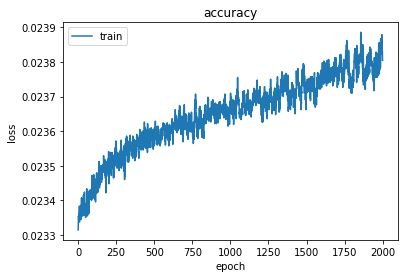

In [60]:
plt.plot(history.history['accuracy'])
plt.title('accuracy')
plt.ylabel('loss')
plt.xlabel('epoch')
plt.legend(['train', 'val'], loc='upper left')
plt.show()

In [25]:
relative_model.save('relative_model2.h5')

# -----------------------------------------------------------------------------------------------------------------

In [11]:
all_Y.shape

(42042, 1)

In [73]:
arr = np.array([])
arr = np.reshape(np.append(arr, np.array([1,2,3])), [-1, 3])

array([[1., 2., 3.]])

In [44]:
arr = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
new_arr = np.delete(arr, 1, 1)
new_arr

array([[ 1,  3,  4],
       [ 5,  7,  8],
       [ 9, 11, 12]])

In [42]:
arr = np.array([[1, 2, 3, 4], [5, 6, 7, 8], [9, 10, 11, 12]])
np.reshape(arr.T[2], [arr.shape[0], -1])

array([[ 3],
       [ 7],
       [11]])

In [36]:
arr.T[2]

array([ 3,  7, 11])

In [22]:
np.reshape(arr[:][2], [arr.shape[0], -1])

ValueError: cannot reshape array of size 4 into shape (3,newaxis)